# DiffusionDB prompt capture demo

## Imports

### External ibraries

In [156]:
from datasets import load_dataset
import torchvision.transforms as transforms
import json
import matplotlib.pyplot as plt
import torch
import numpy as np

### Internal classes and utility functions

In [157]:
from DecoderWithAttention import DecoderWithAttention
from Encoder import Encoder
from DiffusionDBDataLoader import DiffusionDBDataLoader
from checkpoint_utils import save_checkpoint, load_checkpoint

## Demo

### Parameter setup

In [158]:
class Parameters:
    start_epoch = 0
    epochs = 1 
    epochs_since_improvement = 0 
    batch_size = 1
    device = "cpu"
    max_img_width = 720
    max_img_height = 720

    embedding_dimension = 512 
    attention_dimension = 512
    decoder_dimension = 512 
    dropout_fraction = 0.5

    encoder_lr = 1e-4 
    decoder_lr = 4e-4 
    
    fine_tune_encoder = False 

    grad_clip = 5.
    alpha_c = 1.

    print_freq = 100 

### Load data

In [159]:
dataset = load_dataset('poloclub/diffusiondb', '2m_first_1k')["train"]
images_dataset = dataset["image"]
prompts_dataset = dataset["prompt"]

Found cached dataset diffusiondb (C:/Users/46763/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_1k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1)
100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


### Raw input

In [178]:
demo_index = 507

cyberpunk coral emperor, highly detailed, digital painting, trending on artstation, concept art, sharp focus, illustration, art by artgerm and greg rutkowski and magali villeneuve 


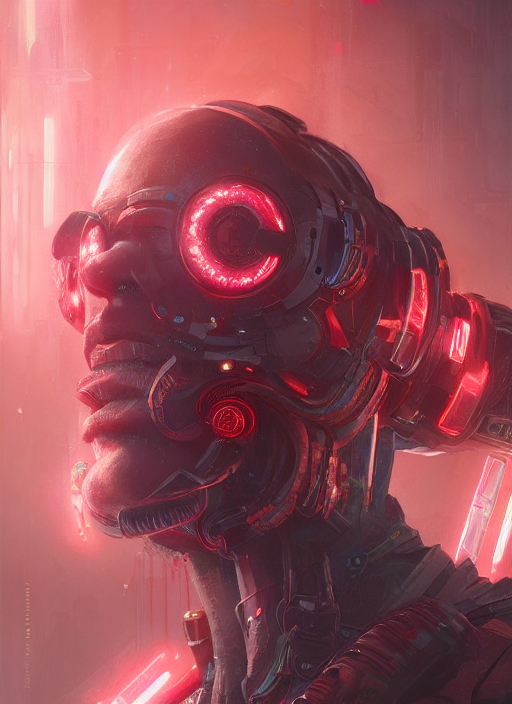

In [180]:
print(prompts_dataset[demo_index])
images_dataset[demo_index]

### Preprocessing

In [181]:
with open('word_map_nostop5.json') as json_file:
    word_map_dict = json.load(json_file)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                                     
demo_loader = DiffusionDBDataLoader(images_dataset[demo_index:demo_index+1], 
                                    prompts_dataset[demo_index:demo_index+1], 
                                    (Parameters.max_img_width, Parameters.max_img_height),
                                    word_map_dict,
                                    Parameters.batch_size, 
                                    transform=normalize,
                                    max_length=15)

Assertions and dimensions
Loading prompts
Setting up transformer
Creating batches


#### Image and prompt after preprocessing

Encoded prompt: [13803, 9521, 4523, 13805, 7472, 13805, 4878, 13805, 9330, 13805, 13805, 5708, 13805, 3094, 13805, 13804]


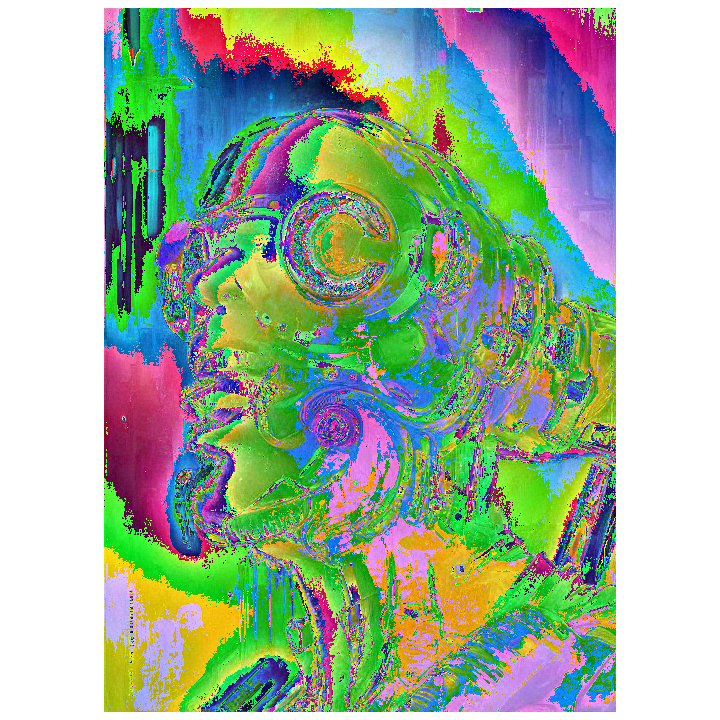

In [182]:
images_transformed, prompts_tokenized, prompts_tokenized_length = next(iter(demo_loader))
image_transformed = images_transformed[0]
prompt_tokenized = prompts_tokenized[0]
print("Encoded prompt:", prompt_tokenized.tolist())
transform_tensor_to_img = transforms.ToPILImage()
transform_tensor_to_img(image_transformed)

### Encoding step

In [183]:
encoder = Encoder()
encoder.fine_tune(Parameters.fine_tune_encoder)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                    lr=Parameters.encoder_lr) if Parameters.fine_tune_encoder else None

decoder = DecoderWithAttention(attention_dimension=Parameters.attention_dimension,
                                embedding_dimension=Parameters.embedding_dimension,
                                decoder_dimension=Parameters.decoder_dimension,
                                vocab_size=len(word_map_dict),
                                dropout_fraction=Parameters.dropout_fraction,
                                device=Parameters.device)
                                
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                    lr=Parameters.decoder_lr)



### Load trained models

In [184]:
encoder, decoder, encoder_optimizer, decoder_optimizer, _, _, _ = load_checkpoint("resnet50_no-unk_no_stop_1000", encoder, decoder, encoder_optimizer, decoder_optimizer, best=True)

#### Image after encoding

Image shape before encoding: torch.Size([3, 720, 720])
Image shape after encoding: torch.Size([14, 14, 2048])
Examples of convolutional filters


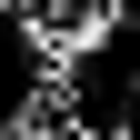

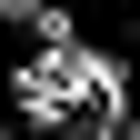

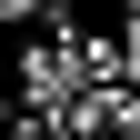

In [185]:
print("Image shape before encoding:", images_transformed[0].shape)

# Forward prop.
image_transformed_batch = encoder(images_transformed)
print("Image shape after encoding:", image_transformed_batch[0].shape)

convolutional_inputs_to_view = [15,69,420]
scale = 10

print("Examples of convolutional filters")

for conv_i in convolutional_inputs_to_view:
    conv_tensor = image_transformed_batch[0][:, :, conv_i]
    conv_img = transform_tensor_to_img(conv_tensor)
    
    display(conv_img.resize(( int(conv_img.width * scale), int(conv_img.height * scale))))

### Decoding step

In [194]:
scores, caps_sorted, decode_lengths, alphas = decoder(image_transformed_batch, prompts_tokenized, prompts_tokenized_length)

In [195]:
print("Words in sentence probabilities for prompt after decoding: \n")
    
print(scores.shape)
print(torch.argmax(scores[0,:,:]))
print(scores)

Words in sentence probabilities for prompt after decoding: 

torch.Size([1, 15, 13806])
tensor(58221)
tensor([[[-7.0852,  1.1518,  2.4387,  ..., -5.0353,  4.5454, -8.1709],
         [-6.0656,  1.4933,  0.6417,  ..., -7.1426,  3.8667, -8.7202],
         [-6.2150,  1.1781,  1.3114,  ..., -5.6280,  2.9414, -5.9463],
         ...,
         [-4.8329, -0.0762,  0.9253,  ..., -5.5203,  4.0254, -5.8851],
         [-3.7593,  1.1804, -0.7211,  ..., -6.4648,  7.3832, -6.2053],
         [-5.7472,  0.6865,  1.1014,  ..., -3.9559,  7.7339, -6.7377]]],
       grad_fn=<CopySlices>)


## Greedy 

In [196]:
" ".join([list(word_map_dict.keys())[list(word_map_dict.values()).index(torch.argmax(word_prob))] for word_prob in scores[0]])

'movie concept beautiful robot detailed digital concept sharp art artgerm dramatic sharp art <end> <end>'

## Keyword search

In [202]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
top = 2

In [203]:
sentence = []

for word_prob in scores[0]:
    best_word_encoded = torch.topk(word_prob, top).indices
    for k in best_word_encoded:
        word_candidate = list(word_map_dict.keys())[list(word_map_dict.values()).index(k)]
        if word_candidate not in ["<pad>", "<start>", "<end>", "<unk>"] and word_candidate not in stop_words:
            if word_candidate not in sentence:
                sentence.append(word_candidate)
" ".join(sentence)

'movie epic concept beautiful portrait robot dramatic detailed digital sharp art artgerm incredible anime'

In [191]:
from tqdm import tqdm
beam_size = 1
device = 'cpu'
vocab_size = len(word_map_dict)
from random import randrange
import torch.nn.functional as F

In [192]:
for i, (image, caps, caplens) in enumerate(
        tqdm(demo_loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):
        
        k = 5
        rand = 3

        imgs = image.to(Parameters.device)
        caps = caps.to(Parameters.device)
        caplens = caplens.to(Parameters.device)

        encoder_out = encoder(imgs)
        encoder_dimension = encoder_out.size(3)
        encoder_out = encoder_out.view(1, -1, encoder_dimension)
        
        num_pixels = encoder_out.size(1)

        encoder_out = encoder_out.expand(k, num_pixels, encoder_dimension)

        k_prev_words = torch.LongTensor([[word_map_dict['<start>']]] * k).to(device)
        seqs = k_prev_words

        top_k_scores = torch.zeros(k, 1).to(device) 

        complete_seqs = list()
        complete_seqs_scores = list()
        incomplete_inds = list()

        step = 1
        h, c = decoder.init_hidden_state(encoder_out)
        
        while True:
        
            embeddings = decoder.embedding(k_prev_words).squeeze(1)  

            awe, _ = decoder.attention(encoder_out, h)  

            gate = decoder.sigmoid(decoder.f_beta(h)) 
            
            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=-1), (h, c)) 

            scores = decoder.fc(h)
            scores = scores[:,:-1]
            scores = F.log_softmax(scores, dim=1)
            
            scores = top_k_scores.expand_as(scores) + scores
            
            top_k_scores_list, top_k_words_list = list(), list()
            for i in range(k):
                if step == 1:
                    top_k_scores, top_k_words = scores[i].topk(rand, 0, True)  
                else:
                    top_k_scores, top_k_words = scores[i].topk(rand, 0, True)  

                indx = randrange(rand)
                
                top_k_scores_list.append(top_k_scores[indx])
                top_k_words_list.append(top_k_words[indx])
            
            top_k_words = torch.LongTensor(top_k_words_list)
            top_k_scores = torch.Tensor(top_k_scores_list)
            
            prev_word_inds = top_k_words / vocab_size 
            next_word_inds = top_k_words % vocab_size 
            
            prev_word_inds = prev_word_inds.long()
            
            seqs = torch.hstack([seqs, next_word_inds.unsqueeze(1)])
        
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                        next_word != word_map_dict['<end>']]
            
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds) 

            if k == 0:
                break
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            if step > 100:
                break
            step += 1
        
        print(complete_seqs_scores)
        joined = []
        for i in range(len(complete_seqs)):
           joined.append(" ".join([list(word_map_dict.keys())[list(word_map_dict.values()).index(ind)] for ind in complete_seqs[i]]))
        print(joined)
        
        

EVALUATING AT BEAM SIZE 1: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

[tensor(-2.8258), tensor(-2.8258), tensor(-4.8285), tensor(-9.2649), tensor(-9.1395)]
['<start> <end>', '<start> <end>', '<start> portrait <end>', '<start> movie cyborg fighting <end>', '<start> portrait highly digital concept <end>']
